In [12]:
%matplotlib inline

import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sky_spot.utils import ClusterType

api = wandb.Api()
plt.rc('font', size=16)

In [23]:
entity, project = "michaelvll", "sky-spot"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 
print(len(runs))

# TAGS = ['baseline']
TAGS = []
NOT_TAGS = ['hidden']
DDLS = {20, 20.4, 23, 24}
STRATEGIES = ['strawman']

def filter_runs(tags, ddls, strategies):
    filters = {
        'env_metadata': lambda x: x['name'] == 'trace' and 'trace_file' in x and '/1.json' in x['trace_file'],
        'strategy_metadata': lambda x: x['name'] in strategies,
        'task_duration_hours': lambda x: x == 20,
        'deadline_hours': lambda x: x in ddls,
    }


    def filter_run(run):
        return all([f(run.config[k]) for k, f in filters.items()])


    run_dfs = []
    new_runs = []
    for run in runs:
        for tag in tags:
            if tag not in run.tags:
                break
        else:
            # all tags found
            for not_tag in NOT_TAGS:
                if not_tag in run.tags:
                    break
            else:
                df = run.history()
                df['Task/Remaining(hours)'] = df['Task/Remaining(seconds)'] / 3600
                if filter_run(run):
                    run_dfs.append((run, df))
    return sorted(run_dfs, key=lambda x: x[0].config['deadline_hours'], reverse=True)

run_dfs = filter_runs(TAGS, DDLS, STRATEGIES)

27


In [24]:
LINE_STYLES = ['-', '--', ':', '-.', ':']
cmap = plt.get_cmap("tab10")
def plot_y(run_dfs, y_name='ClusterType', is_step_plot=True, separate_ax=False):
    if separate_ax:
        fig, ax = plt.subplots(len(run_dfs))
    else:
        fig, ax = plt.subplots()
        ax = [ax] * len(run_dfs)
    strategy, task_duration = None, None
    for i, (run, df) in enumerate(run_dfs):
        label = run.config['deadline_hours']
        label=f'ddl={label}'
        drawstyle = 'steps-pre' if is_step_plot else None
        linestyle = LINE_STYLES[i%len(LINE_STYLES)] if not separate_ax else '-'
        sns.lineplot(x=df['Elapsed'] / 3600, y=df[y_name], label=label, 
                    linestyle=linestyle, color=cmap(i), drawstyle=drawstyle, ax=ax[i])
        
        if separate_ax:
            ax[i].set_title(label)
            ax[i].legend().remove()
    if not separate_ax:
        ax[0].legend(loc='best')
    return fig, ax

## Strawman Strategy

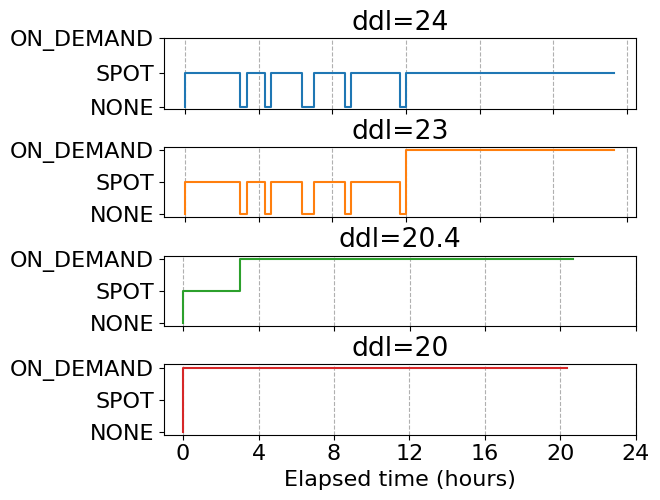

In [25]:
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xticks(list(range(0, 25, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 7)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 25, 4)))
fig.tight_layout(pad=0)

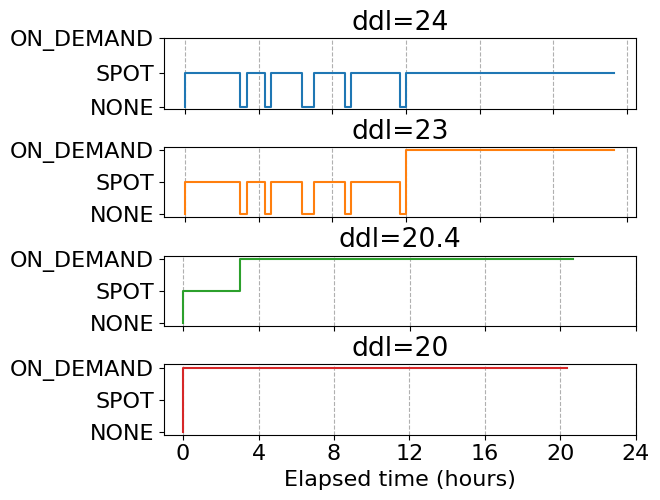

In [26]:
fig, ax = plot_y(run_dfs, y_name='RequestType', separate_ax=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xticks(list(range(0, 25, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 7)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 25, 4)))
fig.tight_layout(pad=0)

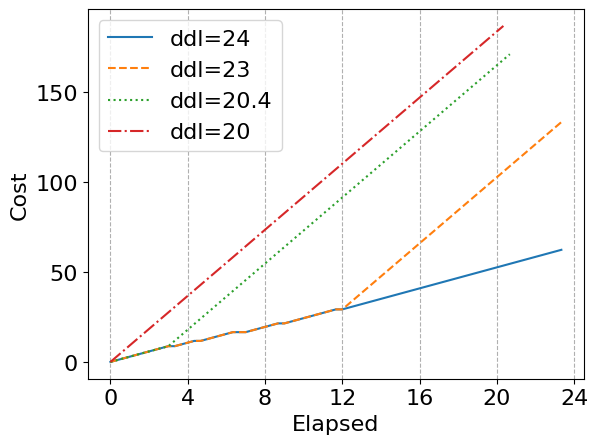

In [27]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False)
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

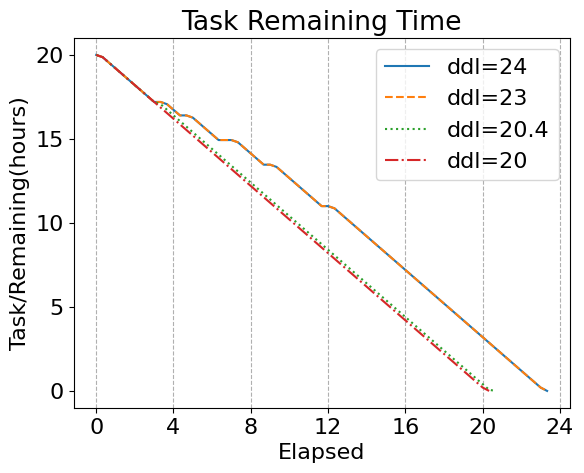

In [28]:
fig, ax = plot_y(run_dfs, y_name='Task/Remaining(hours)', is_step_plot=False)
ax[0].set_title(f'Task Remaining Time')
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

## PairAmortizeStrategy

In [29]:
TAGS = []
DDLs = {24}
STRATEGIES = {'strawman', 'pair_amortize'}

run_dfs = filter_runs(TAGS, DDLs, STRATEGIES)
print(len(run_dfs))

LINE_STYLES = ['-', '--', ':', '-.', ':']
cmap = plt.get_cmap("tab10")
def plot_y(run_dfs, y_name='ClusterType', is_step_plot=True, separate_ax=False):
    if separate_ax:
        fig, ax = plt.subplots(len(run_dfs))
    else:
        fig, ax = plt.subplots()
        ax = [ax] * len(run_dfs)
    strategy, task_duration = None, None
    for i, (run, df) in enumerate(run_dfs):
        config = run.config
        strategy = config['strategy_metadata']['name']
        pair_interval_str = ''
        if 'pair_interval' in config['strategy_metadata']:
            pair_interval = config['strategy_metadata']['pair_interval']
            pair_interval_str = f'+{pair_interval/3600}h'
        use_avg_gain = '+avg' if 'use_avg_gain' in config and config['strategy_metadata']['use_avg_gain'] else ''
        label = f'{strategy}{pair_interval_str}{use_avg_gain}'
        drawstyle = 'steps-pre' if is_step_plot else None
        linestyle = LINE_STYLES[i%len(LINE_STYLES)] if not separate_ax else '-'
        sns.lineplot(x=df['Elapsed'] / 3600, y=df[y_name], label=label, 
                    linestyle=linestyle, color=cmap(i), drawstyle=drawstyle, ax=ax[i])
        
        if separate_ax:
            ax[i].set_title(label)
            ax[i].legend().remove()
    if not separate_ax:
        ax[0].legend(loc='best')
    return fig, ax

4


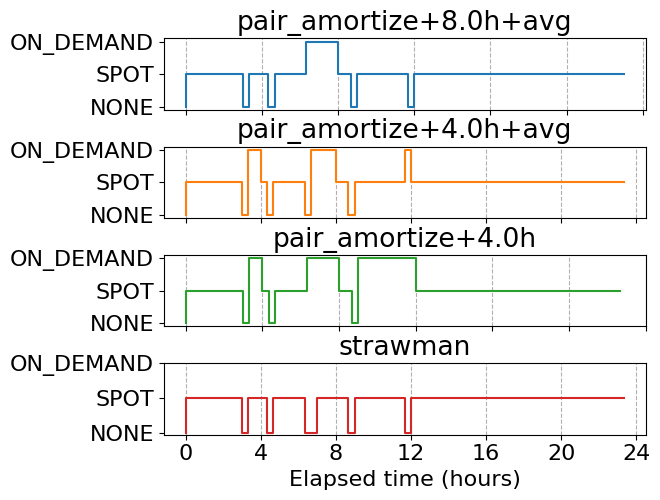

In [30]:
fig, ax = plot_y(run_dfs, y_name='ClusterType', separate_ax=True)
for x in ax:
    x.set_yticks([1, 2, 3])
    x.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
    x.set_ylabel('')
    #  ax.set_title(f'')
    x.set_xticks(list(range(0, 25, 4)))
    x.grid(True, which='major', axis='x', linestyle='--')
    x.set_xticklabels([''] * 7)
    x.set_xlabel('')
ax[-1].set_xlabel('Elapsed time (hours)')
ax[-1].set_xticklabels(list(range(0, 25, 4)))
fig.tight_layout(pad=0)

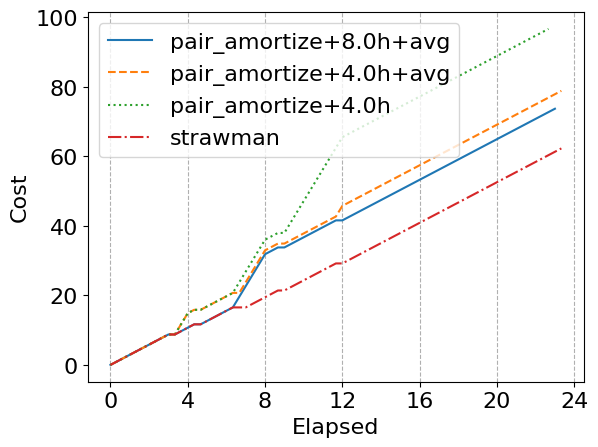

In [31]:
fig, ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False)
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')

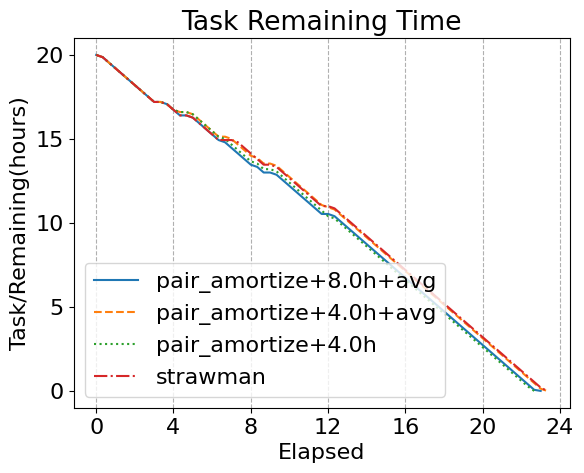

In [32]:
fig, ax = plot_y(run_dfs, y_name='Task/Remaining(hours)', is_step_plot=False)
ax[0].set_title(f'Task Remaining Time')
ax[0].set_xticks(list(range(0, 25, 4)))
ax[0].grid(True, which='major', axis='x', linestyle='--')